In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# The second one includes the Python wrapper? Not sure there is a real difference!
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve

#import random
#import sklearn

#import seaborn as sns
#sns.set(font_scale =1.0)
## need to install conda install python-graphviz to enable this!
#import graphviz
#

#
#from xgboost import plot_tree
#
seed = 156

In [2]:
trainingFeaturesFilename = 'ModelInput/features.csv'
trainingLabelsFilename = 'ModelInput/labels.csv'

trainingFeatures = pd.read_csv(trainingFeaturesFilename)
trainingLabels = pd.read_csv(trainingLabelsFilename)

print("Training features: {}".format(trainingFeatures.shape))
print("Training labels: {}".format(trainingLabels.shape))

tempDF = pd.merge(trainingFeatures, trainingLabels, on='cityId', how='inner')
print("Combined: {}".format(tempDF.shape))

# Start at 2nd column, i.e. exclude cityId
X = pd.get_dummies(trainingFeatures.iloc[:,2:len(trainingFeatures)])
y = tempDF['cityScore'].values
print("X shape:", X.shape)
#print(type(X))
print("y:\n", y)

Training features: (128, 36)
Training labels: (128, 13)
Combined: (128, 48)
X shape: (128, 34)
y:
 [0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 3 2 2 1 2 2 2 1 1 2 2 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 2 2 1 3 0 0 0 1 0 0 0 0 0 0 0 0 2 2 1 2 2 0 0 0
 1 0 1 0 0 0 1 3 3 2 1 3 0 1 1 0 1 0 0 0 0 2 1 2 2 1 3 0 1 1 0 1 0 0 0 0 2
 1 2 2 2 1 2 1 0 1 0 0 0 0 0 0 0 1]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)
print("Train possible labels:")
print(np.unique(y_train))
print("Test possible labels:")
print(np.unique(y_test))
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Train possible labels:
[0 1 2 3]
Test possible labels:
[0 1 2 3]


In [4]:
params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'learning_rate': 0.1,
    'silent': True,
    'n_estimators': 25,
    'num_class': 5
}
num_rounds = 15

In [5]:
watchlist = [(dtest, 'test'), (dtrain, 'train')]
model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-merror:0.615385	train-merror:0.27451
[1]	test-merror:0.615385	train-merror:0.303922
[2]	test-merror:0.615385	train-merror:0.294118
[3]	test-merror:0.653846	train-merror:0.284314
[4]	test-merror:0.615385	train-merror:0.284314
[5]	test-merror:0.576923	train-merror:0.245098
[6]	test-merror:0.576923	train-merror:0.235294
[7]	test-merror:0.576923	train-merror:0.254902
[8]	test-merror:0.576923	train-merror:0.254902
[9]	test-merror:0.576923	train-merror:0.264706
[10]	test-merror:0.538462	train-merror:0.235294
[11]	test-merror:0.576923	train-merror:0.254902
[12]	test-merror:0.538462	train-merror:0.235294
[13]	test-merror:0.538462	train-merror:0.22549
[14]	test-merror:0.538462	train-merror:0.235294


In [6]:
preds = model.predict(dtest)
print("Pred: ", preds.astype('int'))
print(" Act: ", y_test)

Pred:  [2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2]
 Act:  [2 2 1 0 1 2 0 0 1 2 0 2 0 2 0 1 2 1 0 0 3 1 1 2 1 2]


In [7]:
correct = 0

for i in range(len(preds)):
    if (y_test[i] == preds[i]):
        correct += 1

acc = accuracy_score(y_test, preds)

print('Predicated correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))

Predicated correctly: 12/26
Error: 0.5385


In [ ]:
trees_dump = model.get_dump(with_stats=True)

for tree in trees_dump:
    print(tree)

<Figure size 1000x600 with 0 Axes>

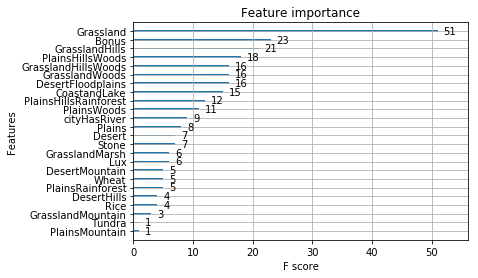

In [8]:
fig = plt.figure(figsize=(10,6), dpi=100)
xgb.plot_importance(model)#, importance_type='gain', xlabel='Gain')

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [10]:
# Adding some randomness and also chaning subsamples..
default_params = {
    'objective': 'multi:softmax',
    'max_depth': 2,
    'learning_rate': 0.3,
    'silent': True,
    'colsample_bytree': 0.6,
    'subsample': 0.7
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv = cv,
    scoring='accuracy'
)

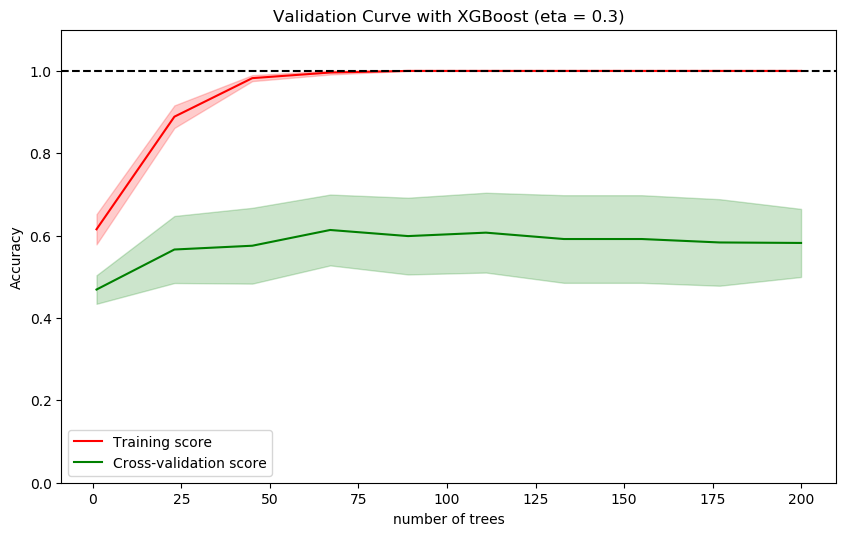

Best cross-validation result (0.61) obtained for 67 trees.


In [11]:
train_scores_mean = np.mean(train_scores, axis =1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)

plt.plot(n_estimators_range,
         train_scores_mean,
         label="Training score",
         color="r")

plt.plot(n_estimators_range,
         test_scores_mean,
         label="Cross-validation score",
         color="g")

plt.fill_between(n_estimators_range,
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees.".format(test_scores_mean[i], n_estimators_range[i]))

params_dist_grid ={
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'n_estimators': [20, 21, 22, 23, 24, 25],
    'learning_rate': [1e-16, 1e-6, 1e-3, 0.1, 0.5, 0.75, 1],
    'subsample': [1e-16, 1e-3, 0.1, 0.5, 0.75, 1],
    'colsample_bytree': [1e-16, 1e-3, 0.1, 0.5, 0.75, 1]
}
params_fixed = {
    'objective': 'multi:softmax',
    'silent': True
}

model_rgrid = RandomizedSearchCV(
    estimator = XGBClassifier(**params_fixed, seed=seed),
    param_distributions=params_dist_grid,
    n_iter=10,
    cv=cv,
    scoring='f1_weighted',
    random_state=seed
)

model_rgrid.fit(X,y)

print("Best f1_weighted obtained: {0}".format(model_rgrid.best_score_))
print("Parameters:")
for key, value in model_rgrid.best_params_.items():
    print("\t{}: {}".format(key, value))

In [28]:
params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'learning_rate': 0.1,
    'silent': True,
    'colsample_bytree': 0.6,
    'subsample': 0.7,
    'n_estimators': 25,
    'num_class': 4
}
num_rounds = 15
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [29]:
model = xgb.train(params, dtrain, num_rounds)
preds = model.predict(dtest)
print("Pred: ", preds.astype('int'))
print(" Act: ", y_test)

Pred:  [2 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 2]
 Act:  [2 2 1 0 1 2 0 0 1 2 0 2 0 2 0 1 2 1 0 0 3 1 1 2 1 2]


In [32]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, preds, average='weighted')))
print('Recall: {0:.2f}'.format(recall_score(y_test, preds, average='weighted')))
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(preds.astype('int'), name='Predicted'),
    margins=True
)

Accuracy: 0.50
Precision: 0.67
Recall: 0.50


Predicted,0,1,2,All
Actual,,,,
0,8,0,0,8
1,6,2,0,8
2,5,1,3,9
3,1,0,0,1
All,20,3,3,26


In [39]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 2
weights[y_train == 2] = 3
weights[y_train == 3] = 6
dtrain= xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test)

In [40]:
model = xgb.train(params, dtrain, num_rounds)
preds = model.predict(dtest)
print("Pred: ", preds.astype('int'))
print(" Act: ", y_test)

Pred:  [2 2 0 1 0 0 0 1 0 1 0 1 0 0 1 0 2 1 0 0 3 0 1 0 1 2]
 Act:  [2 2 1 0 1 2 0 0 1 2 0 2 0 2 0 1 2 1 0 0 3 1 1 2 1 2]


In [41]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, preds, average='weighted')))
print('Recall: {0:.2f}'.format(recall_score(y_test, preds, average='weighted')))
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(preds.astype('int'), name='Predicted'),
    margins=True
)

Accuracy: 0.50
Precision: 0.62
Recall: 0.50


Predicted,0,1,2,3,All
Actual,,,,,
0,5,3,0,0,8
1,5,3,0,0,8
2,3,2,4,0,9
3,0,0,0,1,1
All,13,8,4,1,26


In [53]:
#xgb.to_graphviz(model, num_trees=0)

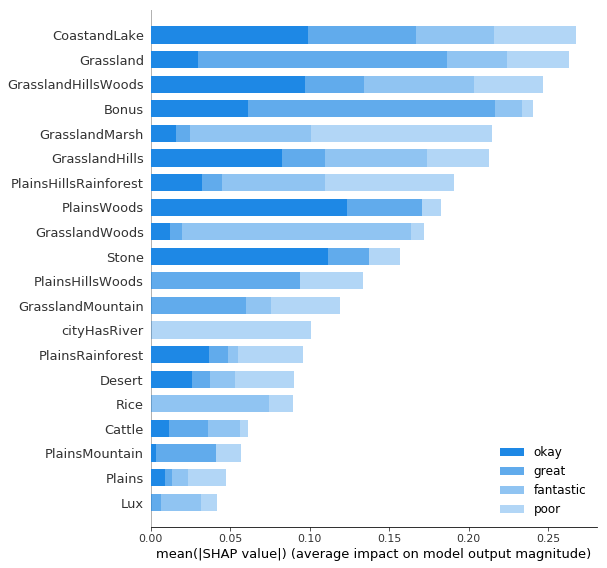

In [59]:
#conda install -c conda-forge shap
import shap

#Load JS visualisation code to Notebook
shap.initjs()

# Explain model's predictions using SHAP values
# same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualise the first prediction's explanation
#shap.force_plot(explainer.expected_value[0], shap_values[0], X)
#shap.dependence_plot("cityHasRiver", shap_values, X)
shap.summary_plot(shap_values, X, class_names=['poor', 'okay', 'great', 'fantastic'])